# Experimento Efeito Fotoeléctrico

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [19]:
plt.rcParams['figure.facecolor'] = 'white'
sns.set_theme()

## Espectro de Emissão dos LEDs Coloridos

In [20]:
colors = [ 'red', 'yellow', 'green', 'blue', 'violet' ]

In [21]:
df_leds = {}
for color in colors: df_leds[color] = pd.read_csv(f'LEDs/{color}.dat', sep='\t')

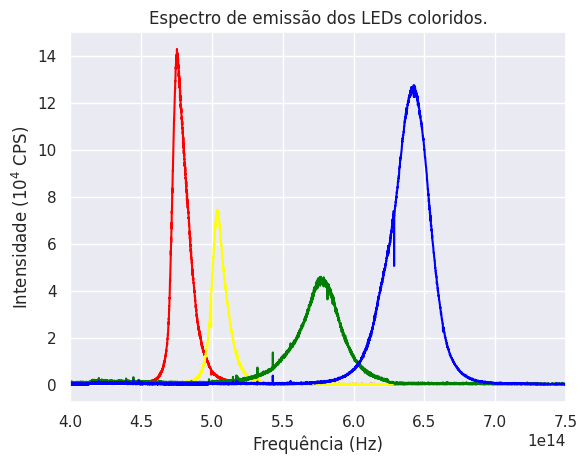

In [39]:
plt.title('Espectro de emissão dos LEDs coloridos.')

for color in colors[:-1]: sns.lineplot(x=df_leds[color]['Frequencia'], y=df_leds[color]['Intensidade']/1E4, color=color)

plt.xlabel('Frequência (Hz)')
plt.ylabel('Intensidade ($10^{4}$ CPS)')

plt.xlim(0.4E15, 0.75E15)
plt.show()